In [1]:
import torch
from mutect3 import data, validation, tensors, networks

%matplotlib inline

In [2]:
GENERATE_PICKLES = False
if GENERATE_PICKLES:
    table_dir = '/Users/davidben/broad/mutect3/tables/'
    pickle_dir = '/Users/davidben/broad/mutect3/pickles/'
    dreams = ['dream1', 'dream2' , 'dream3', 'dream4']
    tumor_samples = ['synthetic.challenge.set1.tumor','background.synth.challenge2.snvs.svs.tumorbackground','IS3.snv.indel.sv','synthetic.challenge.set4.tumour']
    normal_samples = ['synthetic.challenge.set1.normal','synthetic.challenge.set2.normal','G15512.prenormal.sorted','synthetic.challenge.set4.normal']

    for dream, tumor_sample, normal_sample in zip(dreams, tumor_samples, normal_samples):
        print("Generating tensors for " + dream)

        tumor_table, normal_table = (table_dir + dream + suffix for suffix in ('-tumor.table', '-normal.table'))
        pair_train_pickle, small_pair_train_pickle, tumor_train_pickle, normal_train_pickle, test_pickle, small_test_pickle = \
            (pickle_dir + dream + suffix for suffix in ('-pair-train.pickle', '-small-pair-train.pickle', '-tumor-train.pickle', \
                                                       '-normal-train.pickle', '-test.pickle', '-small-test.pickle'))

        # we form a few kinds of training data: tumor data using the normal 
        # (the normal doesn't change the format but helps make better truth guesses)
        print("Generating and pickling tumor tensors for training using tumor and normal")
        pair_train_data = tensors.make_tensors(tumor_table, True, tumor_sample, normal_sample)
        tensors.make_pickle(pair_train_pickle, pair_train_data)

        print("Generating and pickling small (by 10x) tumor tensors for training using tumor and normal")
        tensors.make_pickle(small_pair_train_pickle, pair_train_data[:int(len(pair_train_data)/10)])

        print("Generating and pickling tumor tensors for training using only tumor")
        tumor_train_data = tensors.make_tensors(tumor_table, True, tumor_sample)
        tensors.make_pickle(tumor_train_pickle, tumor_train_data)

        print("Generating and pickling normal tensors for training using only normal")
        normal_train_data = tensors.make_tensors(normal_table, True, normal_sample)
        tensors.make_pickle(normal_train_pickle, normal_train_data)

        print("Generating and pickling tumor tensors for testing using STATUS labels")
        test_data = tensors.make_tensors(tumor_table, False, tumor_sample, normal_sample)
        tensors.make_pickle(test_pickle, test_data)

        print("Generating and pickling small (by 10x) tumor tensors for for testing using STATUS labels")
        tensors.make_pickle(small_test_pickle, test_data[:int(len(test_data)/10)])

In [3]:
BATCH_SIZE = 64
def run_evaluation(training_pickles, test_pickle, num_epochs):
    #Load data
    print("Loading datasets from pickled files")
    train, valid, test = data.make_datasets(training_pickles, test_pickle)
    
    train_false_artifacts = len([_ for datum in train if 'PASS' in datum.mutect_info().filters() and datum.artifact_label() == 1])
    print("Training data includes " + str(train_false_artifacts) + " PASS variants labelled as artifacts.")
    
    # Learn model
    train_loader, valid_loader, test_loader = data.make_data_loaders(train, valid, test)
    model = networks.ReadSetClassifier([20, 20], [10, 10], [10], [], {'normal_artifact'}).float()
    training_metrics = model.train_model(train_loader, valid_loader, test_loader, num_epochs, BATCH_SIZE)
    training_metrics.plot_all_metrics()
    model.get_prior_model().plot_spectra()
    
    #plot purported ROC curve
    validation.get_optimal_f_score(model, test_loader, make_plot=True)

    logit_threshold = model.calculate_logit_threshold(test_loader)
    print("Optimal logit threshold: " + str(logit_threshold))
    
    validation.show_validation_plots(model, test_loader, logit_threshold)

    return model
        

In [4]:
DIR = '/Users/davidben/broad/mutect3/pickles/'
DREAM_1_PAIR = DIR + 'dream1-pair-train.pickle'
DREAM_1_SMALL_PAIR = DIR + 'dream1-small-pair-train.pickle'
DREAM_2_PAIR = DIR + 'dream2-pair-train.pickle'
DREAM_3_PAIR = DIR + 'dream3-pair-train.pickle'
DREAM_4_PAIR = DIR + 'dream4-pair-train.pickle'

DREAM_1_TEST = DIR + 'dream1-test.pickle'
DREAM_1_SMALL_TEST = DIR + 'dream1-small-test.pickle'
DREAM_2_TEST = DIR + 'dream2-test.pickle'
DREAM_3_TEST = DIR + 'dream3-test.pickle'
DREAM_4_TEST = DIR + 'dream4-test.pickle'

Loading datasets from pickled files
Dataset sizes -- training: 7091, validation: 788, test: 1764
Training data includes 2 PASS variants labelled as artifacts.
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Prior log odds: 4.0
Prior log odds: 1.5535004138946533
Prior log odds: 1.0837198495864868
Prior log odds: 1.0071533918380737
Prior log odds: 0.997248113155365
Prior log odds: 0.99845290184021
Prior log odds: 1.0015591382980347
Prior log odds: 1.0050348043441772
Prior log odds: 1.0086102485656738
Prior log odds: 1.0122253894805908
Prior log odds: 1.0158586502075195
Prior log odds: 1.0194966793060303
Prior log odds: 1.0231295824050903
Prior log odds: 1.026749610900879
Prior log odds: 1.030350685119629
Prior log odds: 1.0339274406433105
Prior log odds: 1.037475824356079
Prior log odds: 1.0409923791885376
Prior log odds: 1.0444742441177368
Prior log odds: 1.0479192733764648
Prior log odds: 1.0513254404067993
Prior log odds: 1.054691195487976
Prior log odds: 1.058014988899231
Prior log odds: 1.0

ReadSetClassifier(
  (phi): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=11, out_features=20, bias=True)
      (1): Linear(in_features=20, out_features=20, bias=True)
    )
    (bn): ModuleList()
  )
  (omega): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=9, out_features=10, bias=True)
      (1): Linear(in_features=10, out_features=10, bias=True)
    )
    (bn): ModuleList()
  )
  (rho): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=50, out_features=10, bias=True)
    )
    (bn): ModuleList()
  )
  (snv_output): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=10, out_features=1, bias=True)
    )
    (bn): ModuleList()
  )
  (insertion_output): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=10, out_features=1, bias=True)
    )
    (bn): ModuleList()
  )
  (deletion_output): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=10, out_features=1, bias=True)
    )
    (bn): ModuleList()
  )
  (prior_model): 

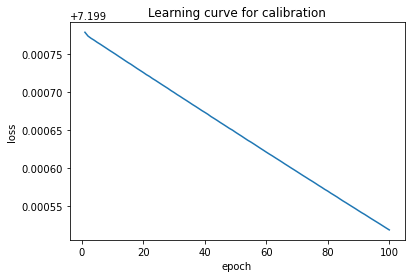

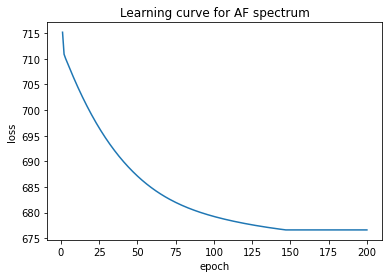

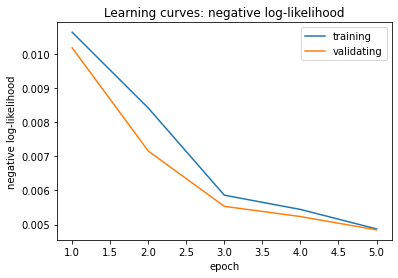

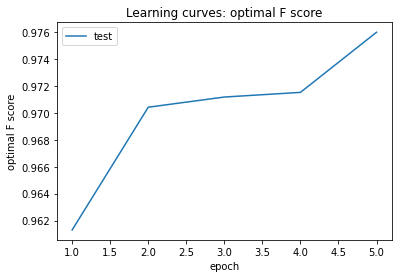

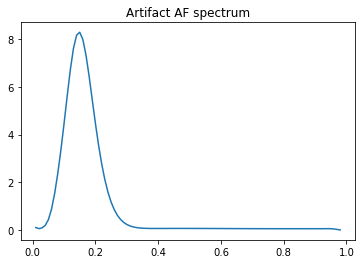

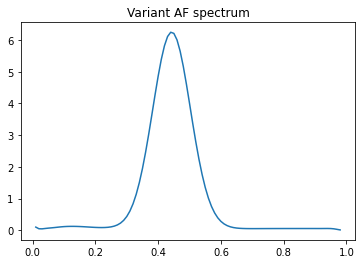

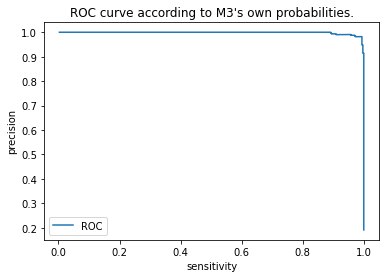

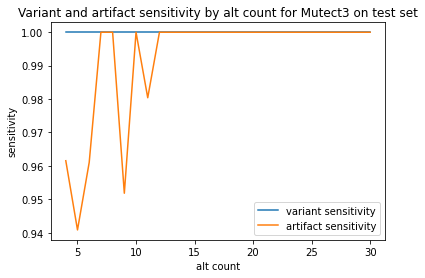

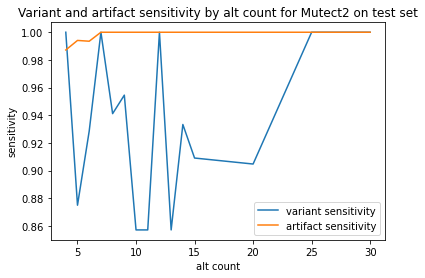

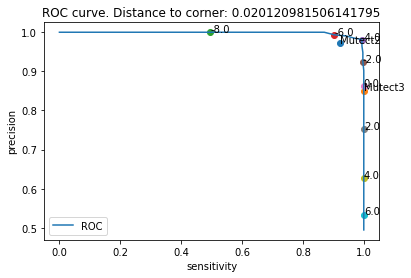

In [5]:
run_evaluation([DREAM_1_SMALL_PAIR], DREAM_1_SMALL_TEST, 5)

Loading datasets from pickled files
Dataset sizes -- training: 70912, validation: 7880, test: 17645
Training data includes 19 PASS variants labelled as artifacts.
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Prior log odds: 4.0
Prior log odds: 1.1901905536651611
Prior log odds: 0.9973337054252625
Prior log odds: 0.9951967597007751
Prior log odds: 1.006512999534607
Prior log odds: 1.0174285173416138
Prior log odds: 1.0268096923828125
Prior log odds: 1.0345875024795532
Prior log odds: 1.0408738851547241
Prior log odds: 1.0458693504333496
Prior log odds: 1.0497990846633911
Prior log odds: 1.0528674125671387
Prior log odds: 1.0552384853363037
Prior log odds: 1.0570313930511475
Prior log odds: 1.0583279132843018
Prior log odds: 1.0591884851455688
Prior log odds: 1.0596678256988525
Prior log odds: 1.05982506275177
Prior log odds: 1.0597246885299683
Prior log odds: 1.0594321489334106
Prior log odds: 1.0590088367462158
Prior log odds: 1.058506965637207
Prior

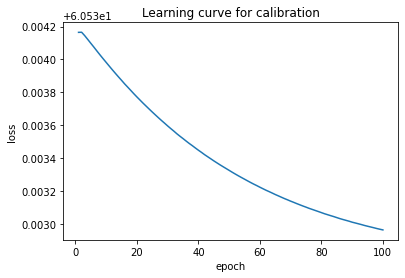

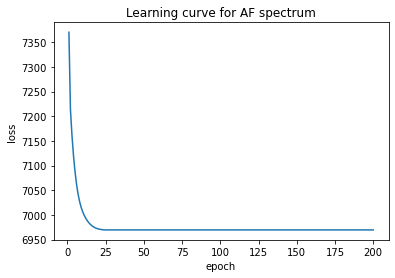

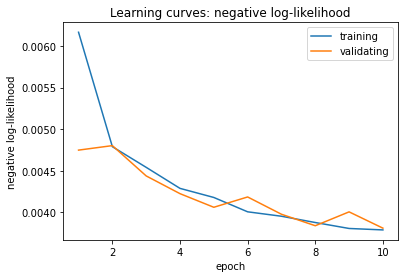

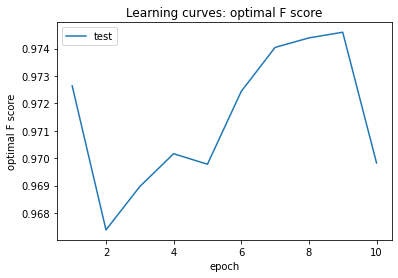

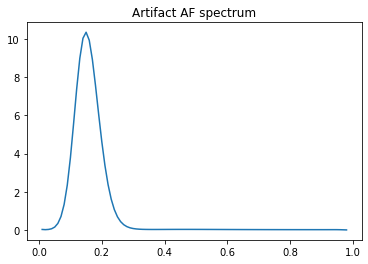

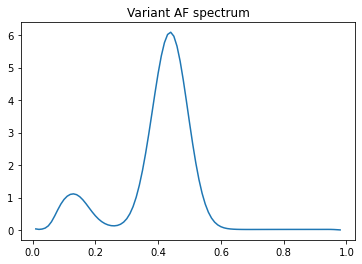

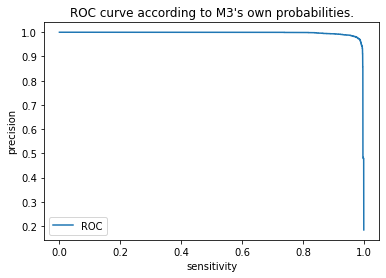

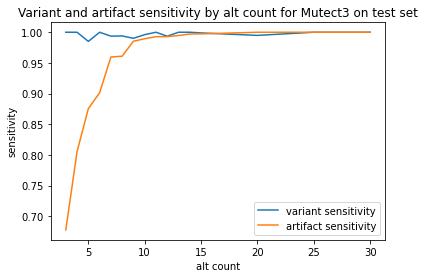

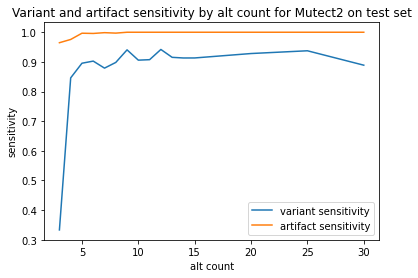

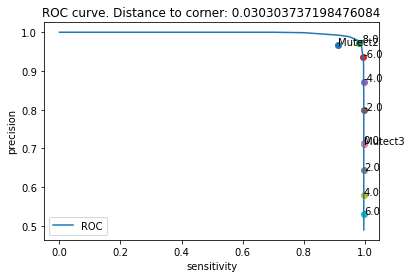

In [6]:
trained_model = run_evaluation([DREAM_1_PAIR], DREAM_1_TEST, 10)

In [8]:
trained_model.confidence, trained_model.max_logit

(Parameter containing:
 tensor([0.0000, 1.0000, 1.4142, 1.7321, 2.0000, 2.2361, 2.4495, 2.6458, 2.8284,
         3.0000, 3.1623]),
 Parameter containing:
 tensor(9.6259))

In [ ]:
run_evaluation([DREAM_2_PAIR], DREAM_2_TEST, 50)

In [ ]:
run_evaluation([DREAM_3_PAIR], DREAM_3_TEST, 50)

In [ ]:
run_evaluation([DREAM_4_PAIR], DREAM_4_TEST, 50)

In [ ]:
run_evaluation([DREAM_1_PAIR], DREAM_3_TEST, 50)

In [ ]:
run_evaluation([DREAM_1_PAIR], DREAM_4_TEST, 50)

In [ ]:
run_evaluation([DREAM_1_PAIR], DREAM_2_TEST, 50)

In [ ]:
run_evaluation([DREAM_2_PAIR], DREAM_1_TEST, 50)